In [1]:
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

models_path = "/home/noam.koren/multiTS/NFT"
if models_path not in sys.path: sys.path.append(models_path)

from models.NFT.NFT import NFT
from models.training_functions import evaluate_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
lookback = 30
horizon = 7
plot = False

def create_datasets(data, lookback, horizon):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:(i + lookback)])
        y.append(data[(i + lookback):(i + lookback + horizon)])
    return np.array(X), np.array(y)

def split_data(X, y):
    n_samples = X.shape[0]
    train_samples = int(n_samples * 0.7)
    val_samples = int(n_samples * 0.15)

    train_X = torch.tensor(X[:train_samples], dtype=torch.float32)
    train_y = torch.tensor(y[:train_samples], dtype=torch.float32)

    val_X = torch.tensor(X[train_samples:train_samples + val_samples], dtype=torch.float32)
    val_y = torch.tensor(y[train_samples:train_samples + val_samples], dtype=torch.float32)

    test_X = torch.tensor(X[train_samples + val_samples:], dtype=torch.float32)
    test_y = torch.tensor(y[train_samples + val_samples:], dtype=torch.float32)
    
    return train_X.to(device), train_y.to(device), val_X.to(device), val_y.to(device), test_X.to(device), test_y.to(device)

n_points = 365 * 4 
time = np.arange(n_points)

n_points = 365 * 4
time = np.arange(n_points)


# Generating the polynomial of degree 3
polynomial1 = 1 * time**3 + 2 * time**2 + 3 * time + 4

polynomial2 = 0 * time**3 + 10 * time**2 + 5 * time + 0

polynomial3 = -5 * time**3 - 15 * time**2 + 5 * time + 3

polynomial4 = -0.7 * time**3 + 6 * time**2 -0.7 * time - 7

polynomial5 = 3 * time**3 - 27 * time**2 - 0.5 * time + 2.1

polynomial6 = 4 * time**3 + 2 * time**2 + 1 * time + 1

polynomial7 = -4 * time**3 - 0.1 * time**2 - 7 * time + 25

polynomial8 = 0.4 * time**3 - 6 * time**2 - 0.1 * time - 6

feature1 = time * 0.05# + np.random.normal(0, 1, n_points) 
feature2 =  time * 0.1# + np.sin(time * (2 * np.pi / 365)) * 10

multivariate_time_series = np.column_stack((polynomial1, polynomial2, polynomial3, polynomial4))#, 
                                            #polynomial5, polynomial6, polynomial7, polynomial8))

if plot:
    plt.figure(figsize=(12, 8))
    plt.plot(time, polynomial1, label='Polynomial 1')
    plt.plot(time, polynomial2, label='Polynomial 2')
    plt.plot(time, polynomial3, label='Polynomial 3')
    plt.plot(time, polynomial4, label='Polynomial 4')
    plt.plot(time, polynomial5, label='Polynomial 5')
    plt.plot(time, polynomial6, label='Polynomial 6')
    plt.plot(time, polynomial7, label='Polynomial 7')
    plt.plot(time, polynomial8, label='Polynomial 8')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Polynomials Over Time')
    plt.legend()
    plt.show()

print(f"multivariate_time_series.shape={multivariate_time_series.shape}")

X, y = create_datasets(multivariate_time_series, lookback, horizon)

train_X, train_y, val_X, val_y, test_X, test_y = split_data(X, y)

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

multivariate_time_series.shape=(1460, 4)


(torch.Size([996, 30, 4]),
 torch.Size([996, 7, 4]),
 torch.Size([213, 30, 4]),
 torch.Size([213, 7, 4]),
 torch.Size([215, 30, 4]),
 torch.Size([215, 7, 4]))

In [3]:
def to_numpy(data):
    """Converts input data to a NumPy array, handling both PyTorch tensors and NumPy arrays."""
    if isinstance(data, torch.Tensor):
        # Move tensor to CPU if it's on a CUDA device, then convert to NumPy
        return data.cpu().numpy() if data.is_cuda else data.numpy()
    elif isinstance(data, np.ndarray):
        # If it's already a NumPy array, just return it
        return data
    else:
        # If it's a scalar (e.g., Python int or float), convert to a NumPy array
        return np.array(data)

def train_model_and_save_evals(lookback, horizon, n_vars, stack_types, thetas_dim, nb_blocks_per_stack, epochs, is_poly):
    model = NFT(
        forecast_length=horizon,
        backcast_length=lookback,
        stack_types=stack_types,
        thetas_dim=thetas_dim,
        n_vars=n_vars,
        nb_blocks_per_stack=nb_blocks_per_stack,
        num_channels_for_tcn=[2, 2],
        is_poly=is_poly
        ).to(device)

    model.compile(loss='mse', optimizer='adam')

    model.fit(
        x_train=train_X, 
        y_train=train_y, 
        validation_data=(val_X, val_y), 
        epochs=epochs,
        batch_size=32, 
        plot_epoch=100
        )

    _, _, _, _, test_mse, _, test_smape, _, _, _, test_mase = evaluate_model(model, train_X, train_y, val_X, val_y, test_X, test_y)
    
    file_path = '/home/noam.koren/multiTS/NFT/results/evaluate_trend_syntatic_data.xlsx'

    if Path(file_path).is_file(): df = pd.read_excel(file_path)
    else: df = pd.DataFrame(columns=["Lookback", "Horizon", "Vars", "Epochs", "Stacks", 
                                     "Dagree", "Blocks", "Is Poly", 
                                   "test_mse", "test_smape", "test_mase"])

    new_row = {"Lookback": lookback, "Horizon": horizon, "Vars": n_vars,
               "Epochs": epochs,  "Stacks": stack_types, 
               "Dagree":thetas_dim, "Blocks": nb_blocks_per_stack, 
               "Is Poly":is_poly, "test_mse": to_numpy(test_mse), 
               "test_smape": to_numpy(test_smape), "test_mase": to_numpy(test_mase)}
    
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    df.to_excel(file_path, index=False)
    



In [4]:
stack_types=('trend', 'trend')
dagree = 3
thetas_dim=(dagree, dagree)
nb_blocks_per_stack=2,
epochs=10
n_vars =2

stacks = [('trend', 'trend')]
d1 = [1,2,3,4]
d2 = [1,2,3,4]
thetas = [(i, j) for i in d1 for j in d2]
thetas = [(1, 1), (2,2), (3,3), (4,4)]
blocks = [1,2,3]
epochs = [15]


| NFT
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=1, backcast_length=30, forecast_length=7, share_thetas=True) at @140529585670752
| --  Stack Trend (#1) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=1, backcast_length=30, forecast_length=7, share_thetas=True) at @140525425188048


Epoch 1, Average loss per data point: 9.048924431182875e+17
Epoch 01/15
63/63 [==============================] - 0s 8ms/step - loss: 904892443118287488.0000 - val_loss: 10327467528606973952.0000
Epoch 2, Average loss per data point: 7.997150279320849e+17
Epoch 02/15
63/63 [==============================] - 0s 4ms/step - loss: 799715027932084864.0000 - val_loss: 10198794981343232000.0000
Epoch 3, Average loss per data point: 7.979241137545556e+17
Epoch 03/15
63/63 [==============================] - 0s 4ms/step - loss: 797924113754555648.0000 - val_loss: 10196550878110941184.0000
Epoch 4, Average loss per data point: 7.979030796081942e+17
Epoch 04/15
63/63 [==============================] - 0s 4ms/step - loss: 797903079608194176.0000 - val_loss: 10198952211506003968.0000
Epoch 5, Average loss per data point: 7.979789674949706e+17
Epoch 05/15
63/63 [==============================] - 0s 4ms/step - loss: 797978967494970624.0000 - val_loss: 10197410696203862016.0000
Epoch 6, Average loss per

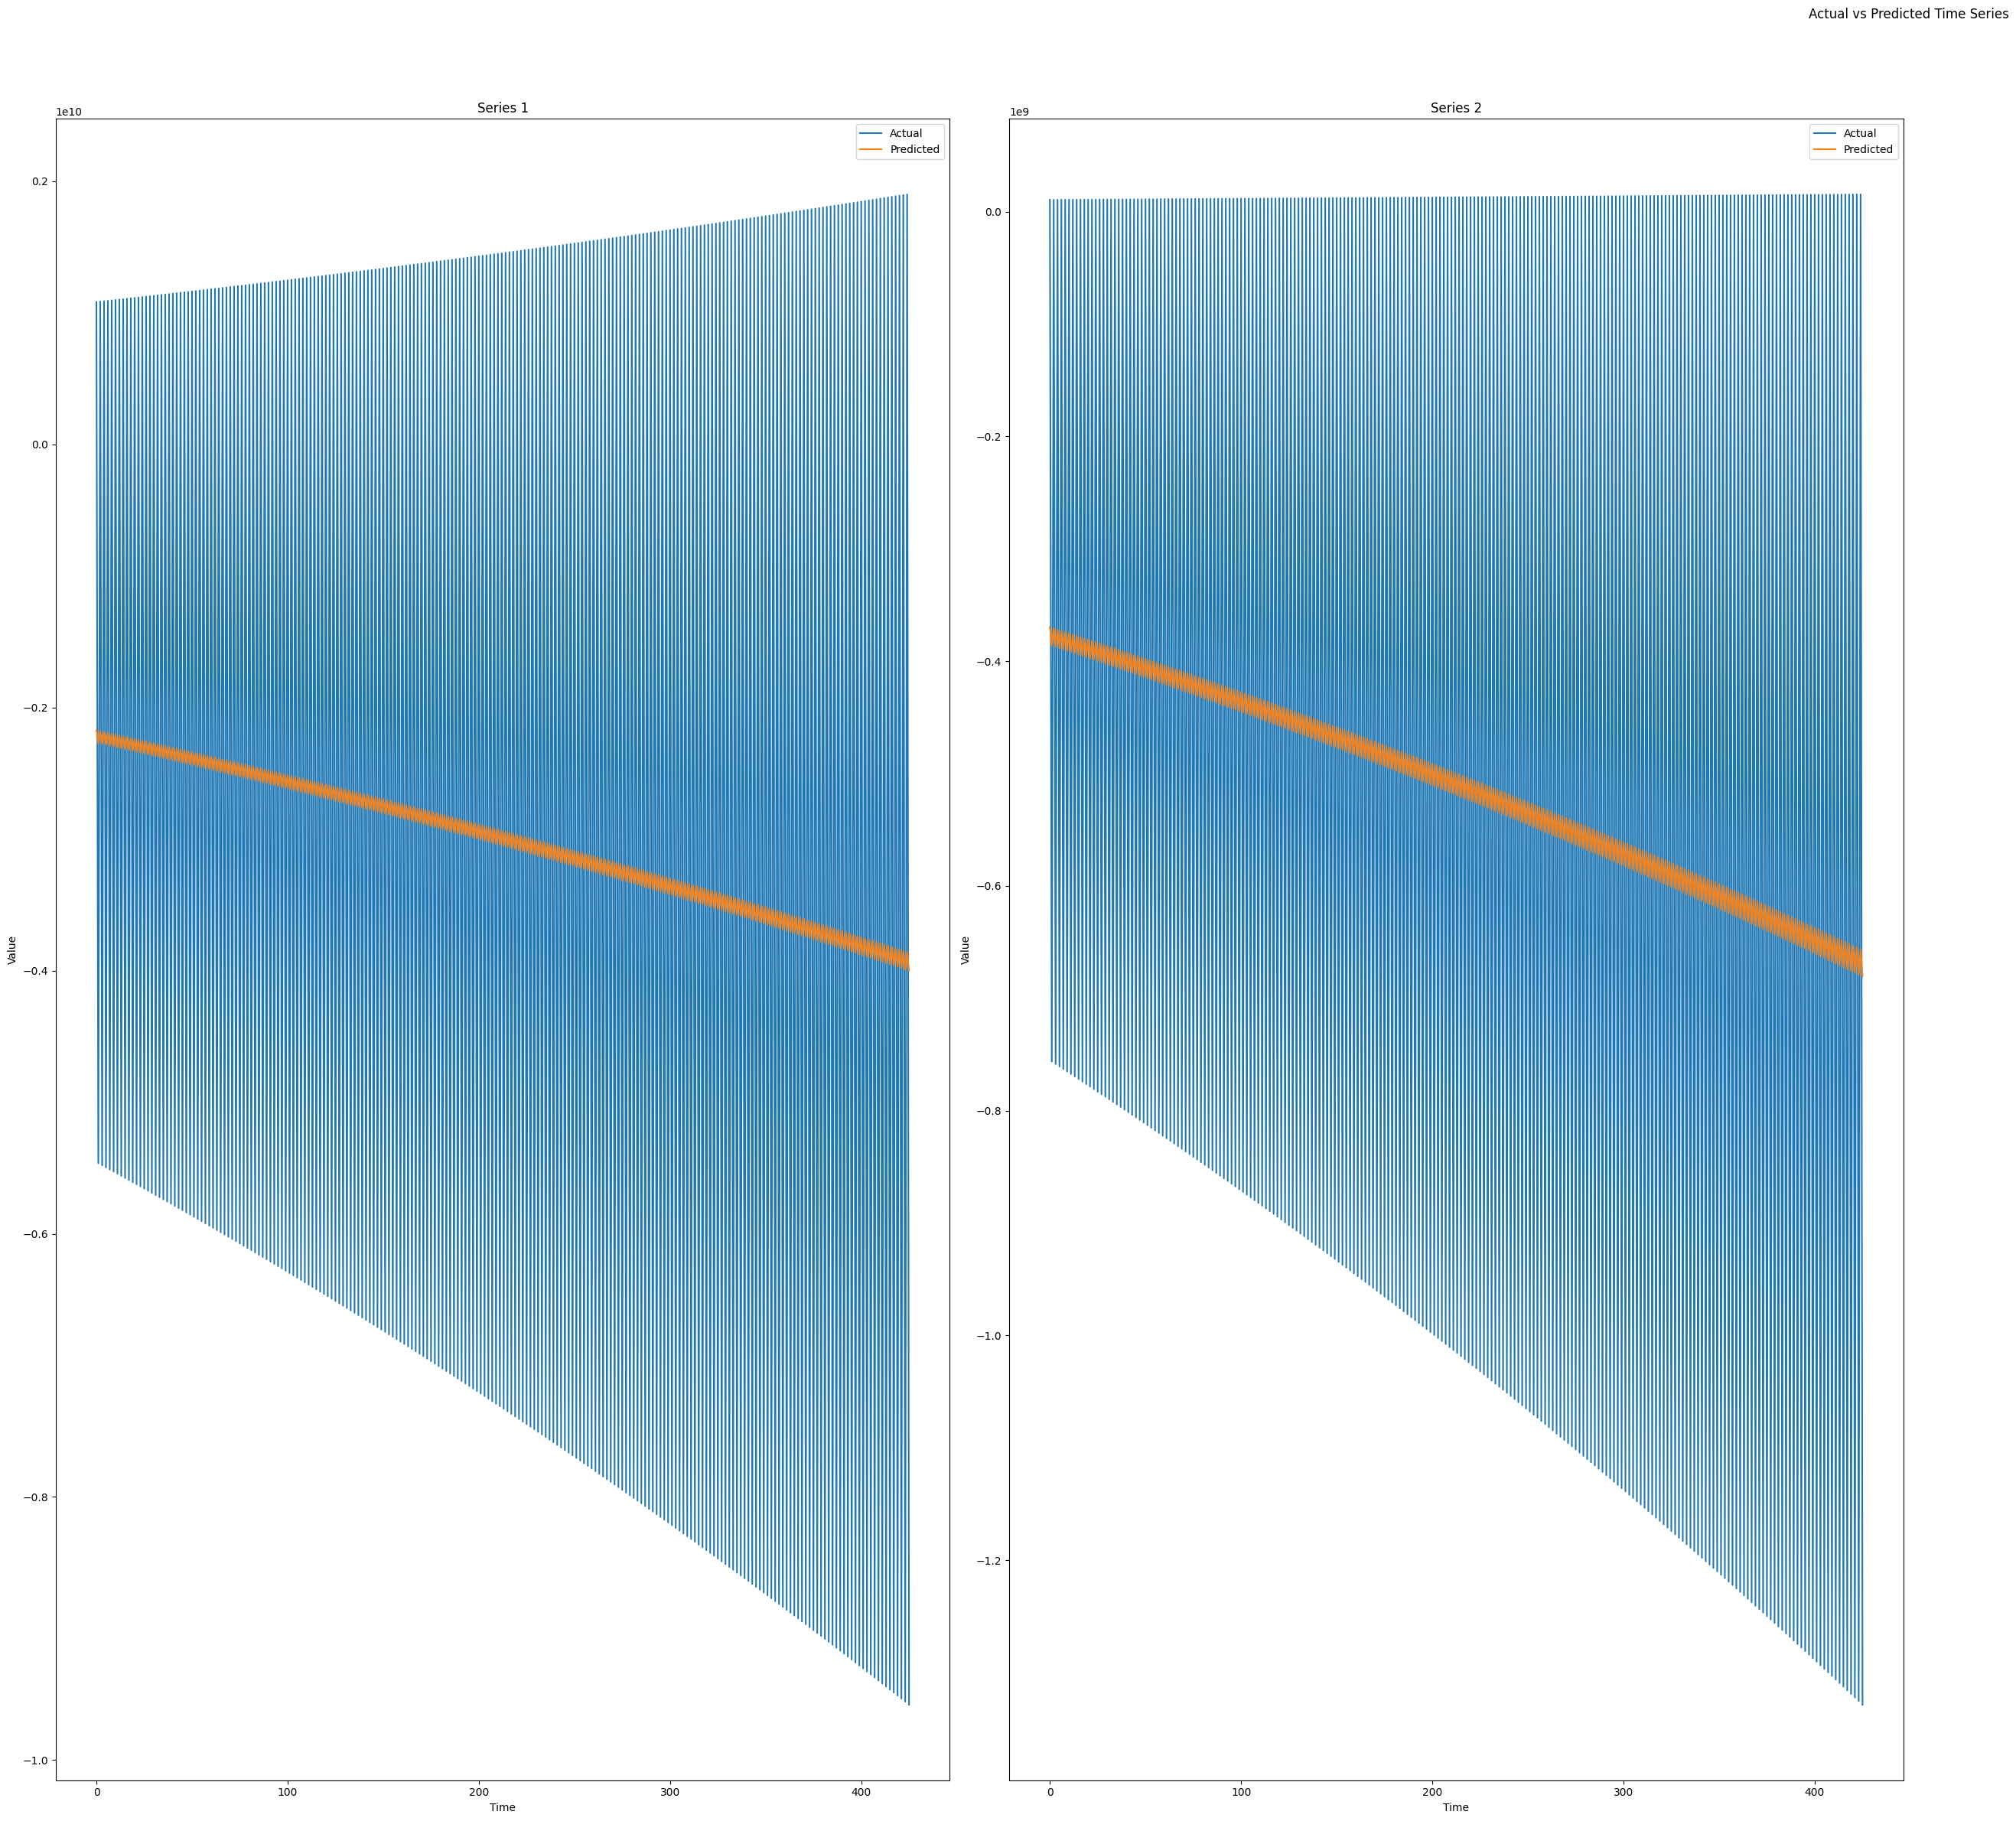

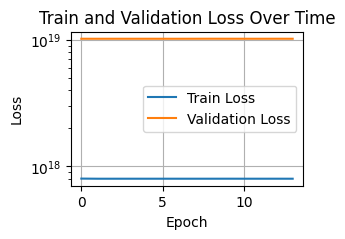

The min train loss is 7.979030796081942e+17 at epoch 3
The min val loss is 1.0196489305459786e+19 at epoch 6



/home/noam.koren/multiTS/NFT/models/training_functions.py:386: UserWarning: Using a target size (torch.Size([996, 7, 4])) that is different to the input size (torch.Size([1992, 7, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  train_mse = F.mse_loss(train_pred.to(device), train_y.to(device))


RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 2

In [5]:
for stack_types in stacks:
    for thetas_dim in thetas:
        for nb_blocks_per_stack in blocks:
            for epoch in epochs:
                train_model_and_save_evals(lookback, horizon, n_vars, stack_types, thetas_dim, nb_blocks_per_stack, epoch, is_poly=True)
                train_model_and_save_evals(lookback, horizon, n_vars, stack_types, thetas_dim, nb_blocks_per_stack, epoch, is_poly=False)